In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

# For the ease of use, we import some submodule of pytorch as alias
import torch
from torch import nn
from torch.nn import functional as F
import os, sys


from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
from IPython.display import display, clear_output
# Find the device that the pytorch will use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



(196, 100, 100, 3)
(196, 4, 4)
<class 'numpy.float32'>
(196, 100, 100, 3) (196, 4, 4) 0.41421357


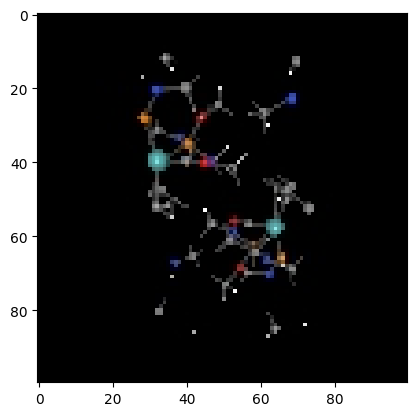

In [2]:

def loadData(Path):
    x = np.load(Path, allow_pickle=True)
    print(x["images"].shape)
    print(x["poses"].shape)
    return x["images"], x["poses"], x["focal"]

path = r"Datasets\3d\100x100_BP1.5\0\data.npz"
images, poses, focal = loadData(path)

print(type(images[0][0][0][0]))
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

t_num = np.random.randint(0, images.shape[0])
testimg, testpose = images[t_num], poses[t_num]


plt.imshow(testimg)
plt.show()

(196, 100, 100, 3)


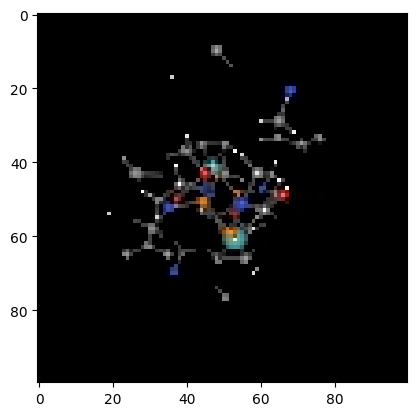

In [3]:
# Load data from npz
'''
The data nerf will use consists of the following:
  images: shape(height, width, 3)
  cam2world: shape(4 ,4)
    it is the same matrix used in common rendering that transfer from camera to the world
  facal_length: shape(1)
    we need this information to find what the direction really is from each pixel in the image
    the focal length we use here is X pixels:

      | \
      |   \    (height/2) / focal
      |     \
      --------
      1.0
'''
# data = np.load("tiny_nerf_data.npz")
# images = data["images"]
print(images.shape)
cam2worlds = poses
# focal_length = np.array([1], dtype=np.float32)
height, width = images.shape[1:3]
focal_length = focal
# # Use one image to test
test_img, test_cam2world = images[1], cam2worlds[1]

# # Move data to the GPU
images = torch.from_numpy(images[:50, ..., :3]).to(device)
cam2worlds = torch.from_numpy(cam2worlds).to(device)
focal_length = torch.from_numpy(focal_length).to(device)
test_img = torch.from_numpy(test_img).to(device)
test_cam2world = torch.from_numpy(test_cam2world).to(device)

# # Show test img
plt.imshow(test_img.detach().cpu().numpy())
plt.show()

In [4]:
def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
  r"""Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

  Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
      is to be computed.
  
  Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
      tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
  """
  # Only works for the last dimension (dim=-1)
  dim = -1
  # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
  cumprod = torch.cumprod(tensor, dim)
  # "Roll" the elements along dimension 'dim' by 1 element.
  cumprod = torch.roll(cumprod, 1, dim)
  # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
  cumprod[..., 0] = 1.
  
  return cumprod

def get_ray_bundle(height: int, width: int, focal_length: float, cam2world: torch.Tensor):
  """Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

  Returns:
    ray_origins (torch.Tensor): (height, width, 3)
      denoting the centers of each ray
    ray_directions (torch.Tensor): (height, width, 3)
      denoting the direction of each ray (a unit vector)
  """
  ii, jj = torch.meshgrid(
      torch.arange(height).to(cam2world),
      torch.arange(width).to(cam2world),
  )
  directions = torch.stack([(jj - width * 0.5) / focal_length,
                            -(ii - height * 0.5) / focal_length,
                            -torch.ones_like(ii)
                           ], dim=-1)
  # add a dimension in the last two dimention (h,w,1,3)
  # to perform matrix mul vector: (h,w,1,3) * (3,3) = (h,w,3,3)
  # then sum in the last dimension: sum((h,w,3,3),-1) = (h,w,3)
  ray_directions = torch.sum(directions[..., None, :] * cam2world[:3, :3], dim=-1)
  # ray origin is just cam2world[:3, -1]
  ray_origins = cam2world[:3, -1].expand(ray_directions.shape)
  return ray_origins, ray_directions

def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize = True
):
  """Compute query 3D points given the "bundle" of rays.

  Args:
    ray_origins (torch.Tensor), ray_directions (torch.Tensor),
    near_thresh (float), far_thresh (float),
    num_samples (int),
    randomize (bool): Whether or not to randomize the sampling of query points.

  Returns:
    query_points (torch.Tensor): (height, width, num_samples, 3)
      Query points along each ray
    depth_values (torch.Tensor): (num_samples)
      Sampled depth values along each ray
  """
  #generate the depth (n)
  depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
  if randomize is True:
    # ray_origins: (h,w,3)
    # noise_shape = (h,w,n)
    noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
    # depth_values: (h,w,n)
    depth_values = depth_values \
        + torch.rand(noise_shape).to(ray_origins) * (far_thresh
            - near_thresh) / num_samples
  
  # (h,w,n,3) = (h,w,1,3) + (h,w,1,3) * (h,w,n,1)
  query_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_values[..., :, None]
  # (h,w,3) / (h,w,1) -> (h,w,3) -> (h,w,1,3)
  length = torch.sqrt(torch.sum(ray_directions * ray_directions, dim = -1))
  ray_directions = ray_directions / length[..., None]
  query_dirs = ray_directions[..., None, :].expand(query_points.shape)
  return query_points, depth_values, query_dirs

def render_volume_density(
    radiance_field: torch.Tensor,
    ray_origins: torch.Tensor,
    depth_values: torch.Tensor
):
  """Differentiably renders the querys computed by the network

  Args:
    radiance_field (torch.Tensor): (height, width, num_samples, 4)
    ray_origins (torch.Tensor), depth_values (torch.Tensor)
  
  Returns:
    rgb_map (torch.Tensor): Rendered RGB image (height, width, 3)
  """

  #compute each query point
  sigma_a = F.relu(radiance_field[..., 3])
  rgb = torch.sigmoid(radiance_field[..., :3])
  one_e_10 = torch.tensor([1e10]).to(ray_origins)
  dists = torch.cat((depth_values[..., 1:] - depth_values[..., :-1],
                  one_e_10.expand(depth_values[..., :1].shape)), dim=-1)
  alpha = 1. - torch.exp(-sigma_a * dists)
  weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

  rgb_map = (weights[..., None] * rgb).sum(dim=-2)
  return rgb_map

def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
):
  """Apply positional encoding to the input.

  Args:
    tensor (torch.Tensor): (h,w,n,3(xyz))
    num_encoding_functions (int): Number of encoding functions
    include_input (bool): Whether or not to include the input
    log_sampling (bool): Sample logarithmically in frequency space
  
  Returns:
    (torch.Tensor): Positional encoding of the input tensor.
  """
  # Trivially, the input tensor is added to the positional encoding.
  encoding = [tensor] if include_input else []
  frequency_bands = None
  if log_sampling:
      frequency_bands = 2.0 ** torch.linspace(
            0.0,
            num_encoding_functions - 1,
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )
  else:
      frequency_bands = torch.linspace(
          2.0 ** 0.0,
          2.0 ** (num_encoding_functions - 1),
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
      )

  for freq in frequency_bands:
      for func in [torch.sin, torch.cos]:
          encoding.append(func(tensor * freq))

  # Special case, for no positional encoding
  if len(encoding) == 1:
      return encoding[0]
  else:
      return torch.cat(encoding, dim=-1)

def get_minibatches(inputs: torch.Tensor, chunksize = 1024 * 8):
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

In [5]:
# The network architecture
'''
basically the network is just a MLP network with reLU
the input is the xyz position (with position encoding)
the output is (RGB, sigma)

sigma is the density
'''
class TinyNerf(nn.Module):
  def __init__(self, filter_size=128, num_encoding=6):
    super().__init__()
    # Input layer (default: 39 -> 128)
    self.layer1 = nn.Linear(3 + 3 * 2 * num_encoding, filter_size)
    # Layer 2 (default: 128 -> 128)
    self.layer2 = nn.Sequential(
        nn.Linear(filter_size, filter_size),
        nn.ReLU(),
        nn.Linear(filter_size, filter_size)
    ) 
    # Layer 3 (default: 128 -> 4)
    self.alpha_out = nn.Linear(filter_size, 1)
    self.layer3 = nn.Linear(filter_size + 3 + 3 * 2 * num_encoding, filter_size // 2)
    self.layer4 = nn.Linear(filter_size // 2, 3)
    
  
  def forward(self, X, D):
    X = F.relu(self.layer1(X))
    X = F.relu(self.layer2(X))
    sigma = self.alpha_out(X)
    X = torch.concat([X, D], dim=-1)
    X = F.relu(self.layer3(X))
    rgb = self.layer4(X)
    X = torch.concat([rgb, sigma], dim=-1)

    return X

In [6]:
def tinyNerf_inference(height, width, focal_length, cam2world,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             num_encoding,
                             encoding_function, get_minibatches_function):
  
  # Get the "bundle" of rays through all image pixels.
  ray_origins, ray_directions = get_ray_bundle(height, width, focal_length, cam2world)
  
  # Sample query points along each ray
  query_points, depth_values, query_dirs = compute_query_points_from_rays(
      ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
  )

  # "Flatten" the query points. (h * w * n, 3)
  flattened_query_points = query_points.reshape((-1, 3))
  flattened_query_dirs = query_dirs.reshape((-1, 3))

  # Encode the query points (h * w * n, 3 + 6 * num_functions)
  encoded_points = encoding_function(flattened_query_points)
  encoded_dirs = encoding_function(flattened_query_dirs)
  encoded_inputs = torch.cat([encoded_points, encoded_dirs], dim = -1)

  # Split the encoded points into "chunks"
  batches = get_minibatches_function(encoded_inputs, chunksize=chunksize)
  predictions = []
  half = 3 + 6 * num_encoding
  for batch in batches:
    predictions.append(model(batch[:,:half], batch[:,half:]))
  radiance_field_flattened = torch.cat(predictions, dim=0)

  # "Unflatten" to obtain the radiance field. (h,w,n,4)
  unflattened_shape = list(query_points.shape[:-1]) + [4]
  radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_predicted = render_volume_density(radiance_field, ray_origins, depth_values)
  
  return rgb_predicted

Loss: 0.008175750263035297


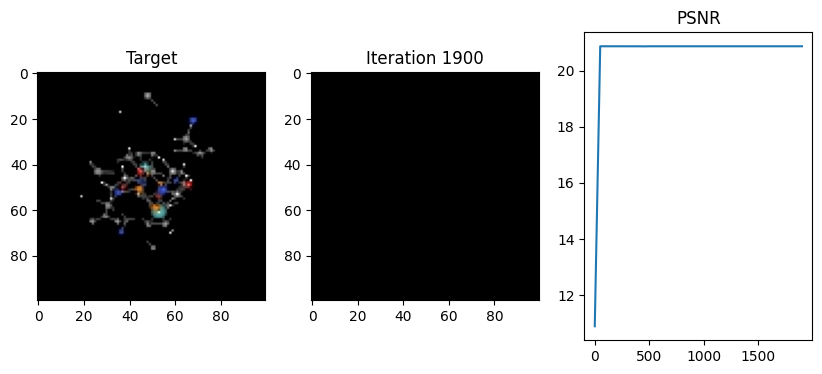

In [7]:
# hyper parameters
filter_size = 128
num_encoding = 6
near_thresh = 2.0
far_thresh = 6.0
depth_samples_per_ray =  64
chunksize = 16384

encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding)

# learning parameters
lr = 5e-3
num_iters = 10000

# record
record = 50
psnrs = []
iternums = []

# define the model
model = TinyNerf(filter_size=filter_size, num_encoding=num_encoding)
# model.load_state_dict(torch.load("TempResult.state"))
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# start training
for i in range(num_iters):

  # Randomly pick an image as the target.
  target_img_idx = np.random.randint(images.shape[0])
  target_img = images[target_img_idx].to(device)
  target_cam2world = cam2worlds[target_img_idx].to(device)

  # Run one iteration of TinyNeRF and get the rendered RGB image.
  predicted_img = tinyNerf_inference(height, width, focal_length,
                                           target_cam2world, near_thresh,
                                           far_thresh, depth_samples_per_ray,
                                           num_encoding,
                                           encode, get_minibatches)
  
  # Compute MSE and train
  loss = F.mse_loss(predicted_img, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Record progress
  if i % record == 0:
    # Render the held-out view
    predicted_img = tinyNerf_inference(height, width, focal_length,
                                           test_cam2world, near_thresh,
                                           far_thresh, depth_samples_per_ray,
                                           num_encoding,
                                           encode, get_minibatches)
    loss = F.mse_loss(predicted_img, test_img)
    
    psnr = -10. * torch.log10(loss)
    psnrs.append(psnr.item())
    iternums.append(i)
    clear_output(wait=True)
    print("Loss:", loss.item())
    plt.figure(figsize=(10, 4))
    plt.subplot(131)
    plt.imshow(test_img.detach().cpu().numpy())
    plt.title("Target")
    plt.subplot(132)
    plt.imshow(predicted_img.detach().cpu().numpy())
    plt.title(f"Iteration {i}")
    plt.subplot(133)
    plt.plot(iternums, psnrs)
    plt.title("PSNR")
    plt.show()

print('Done!')

In [ ]:
k = 4
show_img, show_cam2world = images[k], cam2worlds[k]
predicted_img = tinyNerf_inference(height, width, focal_length,
                                           show_cam2world, near_thresh,
                                           far_thresh, depth_samples_per_ray,
                                           num_encoding,
                                           encode, get_minibatches)
loss = F.mse_loss(predicted_img, show_img)
print("Loss:", loss.item())
psnr = -10. * torch.log10(loss)
print("PSNR:", psnr.item())

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.imshow(predicted_img.detach().cpu().numpy())
plt.title(f"predict")
plt.subplot(122)
plt.imshow(show_img.detach().cpu().numpy())
plt.title("GT")
plt.show()

In [ ]:
torch.save(model.state_dict(),"TempResult.state")